# LDA

In [1]:
# Import dstools (absolute path required, please change to your systems settings)
import importlib
import sys

path = '/dstools-master/dstools/__init__.py'
name = 'dstools'

spec = importlib.util.spec_from_file_location(name, path)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module
spec.loader.exec_module(module)

In [2]:
import math
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


from dstools.datasets import iris

%matplotlib inline

## Einleitung
Die lineare Diskriminanzanalyse (LDA) wird meist als Verfahren zur Dimensionalitätsreduktion im Vorverarbeitungsschritt für Anwendungen der Musterklassifikation und des maschinellen Lernens eingesetzt. Ziel ist die Projektion eines Datensatzes auf einen niedrigdimensionalen Raum mit guter Klassentrennbarkeit, um eine Überanpassung („Fluch der Dimensionalität“) zu vermeiden und gleichzeitig die Rechenkosten zu senken.
Ronald A. Fisher formulierte die lineare Diskriminante 1936 (The Use of Multiple Measurements in Taxonomic Problems), und sie wird auch in der Praxis als Klassifikator verwendet. Die ursprüngliche lineare Diskriminante wurde für ein 2-Klassen-Problem beschrieben und später von C. R. Rao im Jahr 1948 als „lineare Mehrklassen-Diskriminanzanalyse“ oder „Mehrfachdiskriminanzanalyse“ verallgemeinert (The utilization of multiple measurements in problems of biological classification)

Der allgemeine LDA-Ansatz ist einer Hauptkomponentenanalyse sehr ähnlich (weitere Informationen über die PCA finden Sie im vorherigen Artikel Implementierung einer Hauptkomponentenanalyse (PCA) in Python - Schritt für Schritt), aber zusätzlich zur Suche nach den Komponentenachsen, die die Varianz unserer Daten maximieren (PCA), sind wir auch an den Achsen interessiert, die die Trennung zwischen mehreren Klassen maximieren (LDA).

Kurz gesagt besteht das Ziel einer LDA häufig darin, einen Merkmalsraum (einen Datensatz mit $n$-dimensionalen Stichproben) auf einen kleineren Unterraum $k$ (mit $k \leq n-1$) zu projizieren, wobei die klassenunterscheidenden Informationen erhalten bleiben.

Im Allgemeinen trägt die Dimensionalitätsreduktion nicht nur dazu bei, die Rechenkosten für eine bestimmte Klassifizierungsaufgabe zu senken, sondern sie kann auch dazu beitragen, eine Überanpassung zu vermeiden, indem der Fehler bei der Parameterschätzung minimiert wird (“curse of dimensionality”).

### Hauptkomponentenanalyse vs. Lineare Diskriminanzanalyse
Sowohl die lineare Diskriminanzanalyse (LDA) als auch die Hauptkomponentenanalyse (PCA) sind lineare Transformationsverfahren, die häufig zur Dimensionalitätsreduktion eingesetzt werden. Die PCA kann als „unüberwachter“ Algorithmus bezeichnet werden, da sie Klassenbezeichnungen „ignoriert“ und ihr Ziel darin besteht, die Richtungen (die sogenannten Hauptkomponenten) zu finden, die die Varianz in einem Datensatz maximieren. Im Gegensatz zur PCA ist die LDA „überwacht“ und berechnet die Richtungen („lineare Diskriminanten“), die die Achsen darstellen, die die Trennung zwischen mehreren Klassen maximieren.

Obwohl es intuitiv klingen mag, dass LDA der PCA bei einer Mehrklassen-Klassifizierungsaufgabe, bei der die Klassenbezeichnungen bekannt sind, überlegen ist, ist dies nicht immer der Fall.
So zeigen beispielsweise Vergleiche der Klassifizierungsgenauigkeit bei der Bilderkennung nach Verwendung von PCA oder LDA, dass PCA tendenziell besser abschneidet als LDA, wenn die Anzahl der Stichproben pro Klasse relativ klein ist (PCA vs. LDA, A.M. Martinez et al., 2001). In der Praxis ist es auch nicht unüblich, sowohl LDA als auch PCA in Kombination zu verwenden: Z.B. PCA zur Dimensionalitätsreduktion, gefolgt von einer LDA.

<img src="Py_LDA_Example4_Fig1.png">

### Was ist ein „guter“ Merkmalsunterraum?
Nehmen wir an, unser Ziel ist es, die Dimensionen eines $d$-dimensionalen Datensatzes zu reduzieren, indem wir ihn auf einen $k$-dimensionalen Unterraum projizieren (mit $k < d$). Woher wissen wir also, welche Größe wir für $k$ wählen sollten ($k$ ist die Anzahl der Dimensionen des neuen Merkmalsunterraums), und woher wissen wir, ob wir einen Merkmalsraum haben, der unsere Daten „gut“ repräsentiert?

Später werden wir Eigenvektoren (die Komponenten) aus unserem Datensatz berechnen und sie in so genannten Streumatrizen sammeln (d. h. die Zwischenklassen-Streumatrix und die klasseninterne Streumatrix).
Jedem dieser Eigenvektoren ist ein Eigenwert zugeordnet, der uns Aufschluss über die „Länge“ oder „Größe“ der Eigenvektoren gibt.

Wenn wir feststellen, dass alle Eigenwerte eine ähnliche Größe haben, kann dies ein guter Indikator dafür sein, dass unsere Daten bereits auf einen „guten“ Merkmalsraum projiziert sind.

Im anderen Fall, wenn einige der Eigenwerte viel größer als andere sind, könnten wir daran interessiert sein, nur die Eigenvektoren mit den höchsten Eigenwerten zu behalten, da sie mehr Informationen über unsere Datenverteilung enthalten. Umgekehrt sind Eigenwerte, die nahe bei 0 liegen, weniger informativ und wir könnten in Erwägung ziehen, diese für die Konstruktion des neuen Merkmalsunterraums zu streichen.

## Über den Iris-Datensatz

Der Iris-Datensatz enthält Messungen für 150 Irisblüten von drei verschiedenen Arten.

Die drei Klassen im Iris-Datensatz:

1. Iris-setosa (n=50)
1. Iris-versicolor (n=50)
1. Iris-virginica (n=50)

Die vier Merkmale des Iris-Datensatzes:

1. sepal length in cm
1. sepal width in cm
1. petal length in cm
1. petal width in cm

<img src="Py_LDA_Example4_Fig2.png">

In [4]:
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}

### Datensatz einlesen

In [5]:
df = iris()
df.columns = [l for i,l in sorted(feature_dict.items())] + ['class label']

df.tail()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class label
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


\begin{equation}
X =  
 \left (
 {\begin{array}{cccc}
   x_{1\,\text{sepal length}} & x_{1\,\text{sepal width}} & x_{1\,\text{petal length}} & x_{1\,\text{petal width}} \\
   x_{2\,\text{sepal length}} & x_{2\,\text{sepal width}} & x_{2\,\text{petal length}} & x_{2\,\text{petal width}}\\
   \cdots & \cdots & \cdots & \cdots \\
   x_{150\,\text{sepal length}} & x_{150\,\text{sepal width}} & x_{150\,\text{petal length}} & x_{150\,\text{petal width}}\\
  \end{array} } \right ) , y =
  \left (
  {\begin{array}{c}
    w_{\text{setosa}}\\
    w_{\text{setosa}}\\
    \cdots\\
    w_{\text{virginica}}\\
   \end{array} } \right )
\end{equation}

Da es bequemer ist, mit numerischen Werten zu arbeiten, werden wir LabelEncode aus der scikit-learn-Bibliothek verwenden, um die Klassenbezeichnungen in Zahlen umzuwandeln: 1, 2, und 3.

In [6]:
X = df.iloc[:, 0:4].values
y = df.iloc[:, 4].values

enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}

\begin{equation}
y =
  \left (
  {\begin{array}{c}
    w_{\text{setosa}}\\
    w_{\text{setosa}}\\
    \cdots\\
    w_{\text{virginica}}\\
   \end{array} } \right ) \Rightarrow
   \left (
  {\begin{array}{c}
    1\\
    1\\
    \cdots\\
    3\\
   \end{array} } \right )
\end{equation}

### Histogramme und Merkmalsauswahl

Um eine grobe Vorstellung davon zu bekommen, wie die Stichproben unserer drei Klassen $w_1, w_2$ und $w_3$ verteilt sind, wollen wir die Verteilungen der vier verschiedenen Merkmale in 1-dimensionalen Histogrammen darstellen.

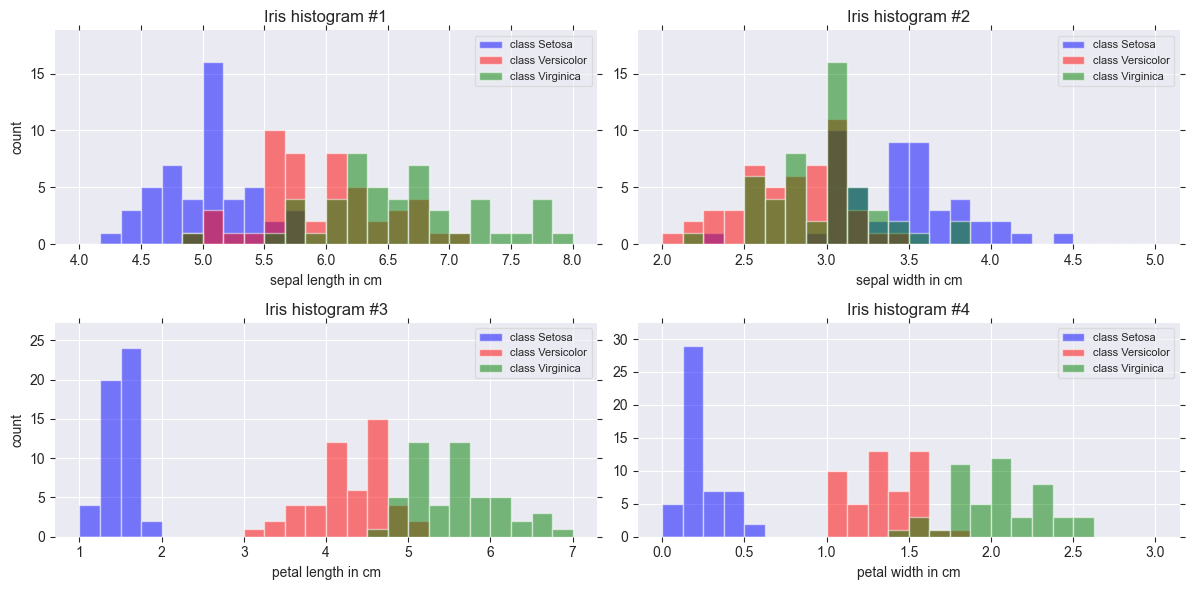

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for ax,cnt in zip(axes.ravel(), range(4)):  

    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)

    # plottling the histograms
    for lab,col in zip(range(1,4), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
                   color=col,
                   label='class %s' %label_dict[lab],
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris histogram #%s' %str(cnt+1))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()       

plt.show()

 Schon bei der Betrachtung dieser einfachen grafischen Darstellungen der Merkmale können wir erkennen, dass die Länge und Breite der Blütenblätter (petal length und petal width) wahrscheinlich besser als potenzielle Merkmale geeignet sind, um zwischen den drei Blumenklassen zu unterscheiden. In der Praxis wäre eine gute Alternative zur Reduzierung der Dimensionalität durch eine Projektion (hier: LDA) eine Technik zur Merkmalsauswahl. Bei niedrigdimensionalen Datensätzen wie Iris wäre ein Blick auf diese Histogramme bereits sehr informativ. 

### Normalitätsannahmen

Es sollte erwähnt werden, dass LDA von normalverteilten Daten, statistisch unabhängigen Merkmalen und identischen Kovarianzmatrizen für jede Klasse ausgeht. Dies gilt jedoch nur für LDA als Klassifikator; LDA zur Dimensionalitätsreduktion kann auch dann recht gut funktionieren, wenn diese Annahmen verletzt werden. Und selbst für Klassifizierungsaufgaben scheint LDA recht robust gegenüber der Verteilung der Daten zu sein:

> “linear discriminant analysis frequently achieves good performances in the tasks of face and object recognition, even though the assumptions of common covariance matrix among groups and normality are often violated (Duda, et al., 2001)” (Tao Li, et al., 2006).

Tao Li, Shenghuo Zhu, and Mitsunori Ogihara. “Using Discriminant Analysis for Multi-Class Classification: An Experimental Investigation.” Knowledge and Information Systems 10, no. 4 (2006): 453–72.)

Duda, Richard O, Peter E Hart, and David G Stork. 2001. Pattern Classification. New York: Wiley.

## LDA in 5 Schritten

Nachdem wir mehrere Vorbereitungsschritte durchlaufen haben, sind unsere Daten endlich bereit für die eigentliche LDA.

### Schritt 1: Berechnung der d-dimensionalen Mittelwertvektoren

In diesem ersten Schritt beginnen wir mit einer einfachen Berechnung der Mittelwertvektoren $m_i, (i=1,2,3)$ der 3 verschiedenen Blumenklassen:

In [8]:
setosa = X[y==1]
versicolor = X[y==2]
virginica = X[y==3]

In [9]:
np.set_printoptions(precision=4)

mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

Mean Vector class 1: [5.006 3.428 1.462 0.246]

Mean Vector class 2: [5.936 2.77  4.26  1.326]

Mean Vector class 3: [6.588 2.974 5.552 2.026]



### Schritt 2: Berechnung der Streumatrizen

Nun berechnen wir die beiden 4x4-dimensionalen Matrizen: Die Streumatrix innerhalb der Klasse und die Streumatrix zwischen den Klassen:

#### Within-class scatter matrix $S_W$

Die klasseninterne Streumatrix $S_W$ wird durch die folgende Gleichung berechnet:

\begin{equation}
S_W = \sum_{i=1}^{c} S_i
\end{equation}

wobei die Streumatrix für jede Klasse wie folgt lautet

\begin{equation}
S_i = \sum_{\mathbf{x} \in D_i}^n (\mathbf{x} - \mathbf{m}_i)(\mathbf{x} - \mathbf{m}_i)^T
\end{equation}

und $\mathbf{m}_i$ is der Vektor der Mittelwerte

\begin{equation}
\mathbf{m}_i = \frac{1}{n_i}\sum_{\mathbf{x} \in D_i}^n \mathbf{x}_k
\end{equation}

In [10]:
S_W = np.zeros((4,4))
for cl,mv in zip(range(1,4), mean_vectors):    
    class_sc_mat = np.zeros((4,4))                  # scatter matrix for every class
    
    for row in X[y == cl]:        
        row, mv = row.reshape(4,1), mv.reshape(4,1) # make column vectors
        #cnt += 1
        #print('cnt %s mv:%s row: %s \n ' %(cnt, mv, row))
        class_sc_mat += (row-mv).dot((row-mv).T)
        #print('cnt %s S_i %s\n' %(cnt,class_sc_mat))
    if cl < 3: # virginica ausschließen wie im fisher-paper
        S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W)

within-class Scatter Matrix:
 [[19.1434  9.0356  9.7634  3.2394]
 [ 9.0356 11.8658  4.6232  2.4746]
 [ 9.7634  4.6232 12.2978  3.8794]
 [ 3.2394  2.4746  3.8794  2.4604]]


#### Alternative zur Berechnung von $S_{W}$

Alternativ könnten wir auch die Klassen-Kovarianz-Matrizen berechnen, indem wir den Skalierungsfaktor $\frac{1}{N-1}$ zur klasseninternen Streumatrix hinzufügen, so dass unsere Gleichung wie folgt lautet

\begin{equation}
\Sigma_i = \frac{1}{N_i - 1} \sum_{\mathbf{x} \in D_i}^n (\mathbf{x} - \mathbf{m}_i)(\mathbf{x} - \mathbf{m}_i)^T
\end{equation}

und 

\begin{equation}
S_W = \sum_{i=1}^{c} (N_i - 1) \Sigma_1
\end{equation}

wobei $N_i$ der Stichprobenumfang der jeweiligen Klasse ist (hier: 50), und in diesem speziellen Fall können wir den Term $(N_i-1)$ weglassen
weglassen, da alle Klassen den gleichen Stichprobenumfang haben.

Die resultierenden Eigenräume sind jedoch identisch (identische Eigenvektoren, nur die Eigenwerte sind um einen konstanten Faktor anders skaliert).

#### Streuungsmatrix zwischen den Klassen $S_B$

Die **Zwischenklassen-Streuungsmatrix** $S_B$ wird durch die folgende Gleichung errechnet:

\begin{equation}
S_B = \sum_{i=1}^{c} N_i (\mathbf{m}_i - \mathbf{m})(\mathbf{m}_i - \mathbf{m})^T
\end{equation}

wobei $\mathbf{m}$ der Gesamtmittelwert ist und $\mathbf{m}_i$ und $N_i$ die Stichprobenmittelwerte und -größen der jeweiligen Klassen sind.

In [11]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) # make column vector
    overall_mean = overall_mean.reshape(4,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[ 63.2121 -19.9527 165.2484  71.2793]
 [-19.9527  11.3449 -57.2396 -22.9327]
 [165.2484 -57.2396 437.1028 186.774 ]
 [ 71.2793 -22.9327 186.774   80.4133]]


### Schritt 3: Lösen des verallgemeinerten Eigenwertproblems

Als nächstes lösen wir das verallgemeinerte Eigenwertproblem für die Matrix $S_W^{-1}S_B$, um die linearen Diskriminanten zu erhalten.

In [12]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[-0.0665]
 [-0.3506]
 [ 0.4089]
 [ 0.8399]]
Eigenvalue 1: 5.73e+01

Eigenvector 2: 
[[-7.3405e-04]
 [-2.3051e-01]
 [ 3.5664e-01]
 [-9.0536e-01]]
Eigenvalue 2: 6.76e-01

Eigenvector 3: 
[[-0.7259]
 [ 0.0462]
 [-0.0127]
 [ 0.6861]]
Eigenvalue 3: 2.32e-15

Eigenvector 4: 
[[ 0.1034]
 [-0.3683]
 [-0.4355]
 [ 0.8148]]
Eigenvalue 4: 6.50e-15


In [13]:
eig_vecs[:,3].reshape(4,1)

array([[ 0.1034],
       [-0.3683],
       [-0.4355],
       [ 0.8148]])

**Anmerkung**
Je nachdem, welche Version von NumPy und LAPACK wir verwenden, kann es sein, dass wir die Matrix $W$ mit umgekehrten Vorzeichen erhalten. Bitte beachten Sie, dass dies kein Problem ist; wenn $v$ ein Eigenvektor einer Matrix $\Sigma$ ist, haben wir

\begin{equation}
\Sigma v = \lambda v.
\end{equation}

Hier ist $\lambda$ der Eigenwert, und $v$ ist ebenfalls ein Eigenvektor, der denselben Eigenwert hat, da
\begin{equation}
\Sigma(−v)=−−vΣ=−λv=λ(−v).
\end{equation}

Nach dieser Zerlegung unserer quadratischen Matrix in Eigenvektoren und Eigenwerte wollen wir kurz rekapitulieren, wie wir diese Ergebnisse interpretieren können. Wie wir uns aus unserem ersten linearen Algebra-Unterricht in der Schule oder am College erinnern, liefern uns sowohl die Eigenvektoren als auch die Eigenwerte Informationen über die Verzerrung einer linearen Transformation: Die Eigenvektoren geben im Wesentlichen die Richtung dieser Verzerrung an, und die Eigenwerte sind der Skalierungsfaktor für die Eigenvektoren, der das Ausmaß der Verzerrung beschreibt.

Wenn wir die LDA zur Dimensionalitätsreduktion durchführen, sind die Eigenvektoren wichtig, da sie die neuen Achsen unseres neuen Merkmalsunterraums bilden werden; die zugehörigen Eigenwerte sind von besonderem Interesse, da sie uns sagen, wie „informativ“ die neuen „Achsen“ sind.

Überprüfen wir kurz unsere Berechnung:

#### Überprüfen der Eigenvektor-Eigenwert-Berechnung
Eine schnelle Überprüfung, ob die Eigenvektor-Eigenwert-Berechnung korrekt ist und die Gleichung erfüllt:

\begin{equation}
Av = \lambda v
\end{equation}

wobei

$$A = S_W^{-1}S_B$$

$v$ Eigenvektor und 

$\lambda$ Eigenwert.

In [15]:
for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(4,1)
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv),
                                         eig_vals[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)
print('ok')

ok


In [16]:
eigv = eig_vecs[:,0].reshape(4,1)
res = np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv),
                                         eig_vals[0] * eigv,
                                         decimal=6, err_msg='', verbose=True)

### Schritt 4: Auswahl der linearen Diskriminanten für den neuen Merkmalsunterraum

#### Sortieren der Eigenvektoren nach abnehmenden Eigenwerten
Erinnern Sie sich an die Einleitung, dass wir nicht nur daran interessiert sind, die Daten in einen Unterraum zu projizieren, der die Klassentrennbarkeit verbessert, sondern auch die Dimensionalität unseres Merkmalsraums reduziert (wobei die Eigenvektoren die Achsen dieses neuen Merkmalsunterraums bilden werden).

Die Eigenvektoren definieren jedoch nur die Richtungen der neuen Achse, da sie alle die gleiche Einheitslänge 1 haben.

Um also zu entscheiden, welche(n) Eigenvektor(en) wir für unseren niederdimensionalen Unterraum fallen lassen wollen, müssen wir uns die entsprechenden Eigenwerte der Eigenvektoren ansehen. Grob gesagt enthalten die Eigenvektoren mit den niedrigsten Eigenwerten die wenigsten Informationen über die Verteilung der Daten, und das sind diejenigen, die wir verwerfen wollen.

Der übliche Ansatz besteht darin, die Eigenvektoren vom höchsten zum niedrigsten korrespondierenden Eigenwert zu ordnen und die obersten $k$ Eigenvektoren auszuwählen.

In [17]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

57.28102320105187
0.6756802855175003
6.5015129820376605e-15
2.317899818066737e-15


**Anmerkung**

Wenn wir einen Blick auf die Eigenwerte werfen, können wir bereits sehen, dass 2 Eigenwerte nahe bei 0 liegen. Der Grund, warum diese nahe bei 0 liegen, ist nicht, dass sie nicht informativ sind, sondern es liegt an der Ungenauigkeit der Gleitkommazahlen. 

Eigentlich sollten diese beiden letzten Eigenwerte genau Null sein: Bei LDA ist die Anzahl der linearen Diskriminanten höchstens $c-1$, wobei $c$ die Anzahl der Klassenlabels ist, da die Zwischenstreumatrix $S_B$ die Summe von $c$ Matrizen mit Rang 1 oder weniger ist. 

Man beachte, dass im seltenen Fall der perfekten Kollinearität (alle ausgerichteten Stichprobenpunkte liegen auf einer Geraden) die Kovarianzmatrix den Rang 1 hätte, was zu nur einem Eigenvektor mit einem Eigenwert ungleich Null führen würde.

Wir drücken nun die „erklärte Varianz“ als Prozentsatz aus:

In [18]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 98.83%
eigenvalue 2: 1.17%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


Das erste Eigenpaar ist bei weitem das informativste, und wir würden nicht viel Information verlieren, wenn wir auf der Grundlage dieses Eigenpaars ein 1D-Merkmal bilden würden.

#### Auswahl von k Eigenvektoren mit den größten Eigenwerten

Nachdem wir die Eigenpaare nach abnehmenden Eigenwerten sortiert haben, ist es nun an der Zeit, unsere $k \times d$-dimensionale Eigenvektor-Matrix $W$ (hier $4 \times 2$: basierend auf den 2 informativsten Eigenpaaren) zu konstruieren und damit den anfänglichen 4-dimensionalen Merkmalsraum auf einen 2-dimensionalen Merkmalsunterraum zu reduzieren.

In [19]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[-6.6453e-02 -7.3405e-04]
 [-3.5057e-01 -2.3051e-01]
 [ 4.0893e-01  3.5664e-01]
 [ 8.3992e-01 -9.0536e-01]]


### Schritt 5: Transformieren der Stichproben in den neuen Unterraum
Im letzten Schritt verwenden wir die soeben berechnete $4 \times  2$-dimensionale Matrix $W$, um unsere Stichproben auf den neuen Unterraum zu transformieren, und zwar mit der Gleichung

\begin{equation}
Y = X \cdot W
\end{equation}

wobei $X$ eine $n \times  d$-dimensionale Matrix ist, die die $n$ Stichproben darstellt, und $Y$ die transformierten $n \times  k$-dimensionalen Stichproben im neuen Unterraum sind.

In [20]:
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional."

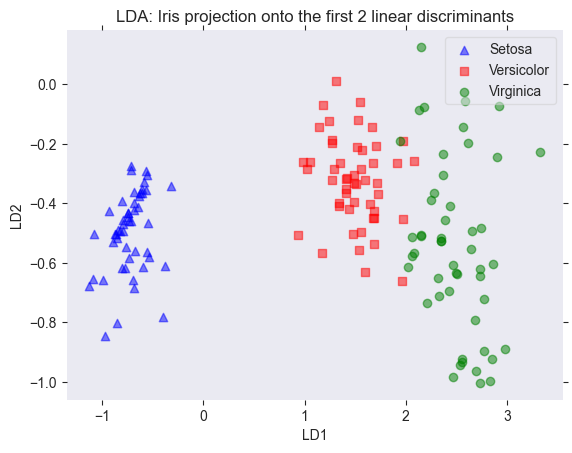

In [21]:
def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()

Das obige Streudiagramm stellt unseren neuen Merkmalsunterraum dar, den wir mittels LDA konstruiert haben. Wir können sehen, dass die erste lineare Diskriminante „LD1“ die Klassen recht gut trennt. Die zweite Diskriminante, „LD2“, liefert jedoch nicht viele wertvolle Informationen, was wir bereits bei der Betrachtung der gerankten Eigenwerte in Schritt 4 festgestellt haben.

In [22]:
sklearn_pca = sklearnPCA(n_components=2)
X_pca = sklearn_pca.fit_transform(X)

def plot_pca():

    ax = plt.subplot(111)

    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_pca[:,0][y == label],
                y=X_pca[:,1][y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('PC1')
    plt.ylabel('PC2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('PCA: Iris projection onto the first 2 principal components')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.tight_layout
    plt.grid()

    plt.show()

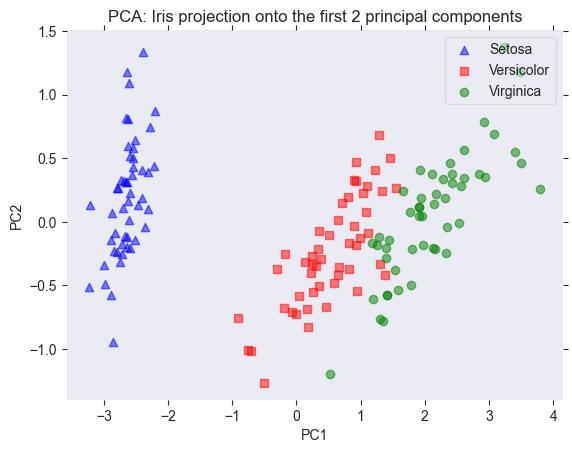

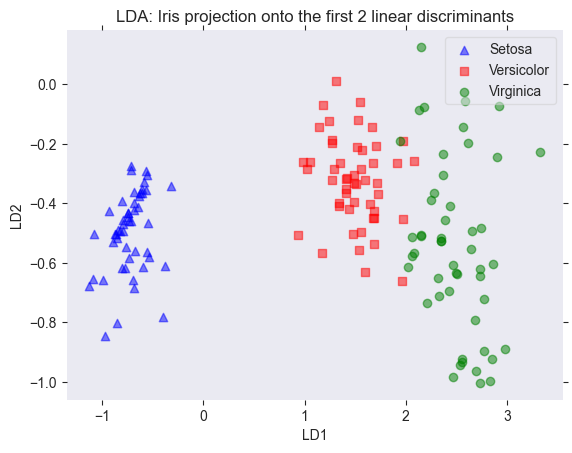

In [23]:
plot_pca()
plot_step_lda()

Die beiden obigen Diagramme bestätigen sehr schön, was wir zuvor diskutiert haben: Während die PCA die größte Varianz im gesamten Datensatz berücksichtigt, liefert die LDA die Achsen, die die größte Varianz zwischen den einzelnen Klassen ausmachen.

## LDA mit scikit-learn

Nachdem wir nun gesehen haben, wie eine lineare Diskriminanzanalyse Schritt für Schritt funktioniert, gibt es auch einen bequemeren Weg, um dasselbe über die LDA-Klasse zu erreichen, die in der scikit-learn-Bibliothek implementiert ist.

In [24]:
# LDA
sklearn_lda = LDA()
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

In [25]:
sklearn_lda.explained_variance_ratio_

array([0.9912, 0.0088])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=147)

In [27]:
sklearn_lda.means_

array([[5.006, 3.428, 1.462, 0.246],
       [5.936, 2.77 , 4.26 , 1.326],
       [6.588, 2.974, 5.552, 2.026]])

In [28]:
def plot_scikit_lda(X, title):

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X[:,0][y == label],
                    y=X[:,1][y == label] * -1, # flip the figure
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label_dict[label])

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title)

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

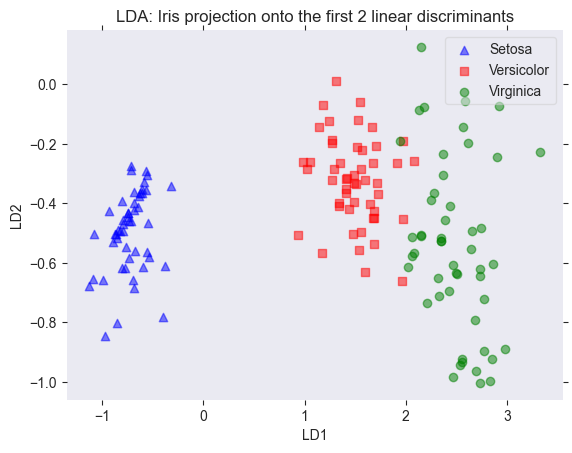

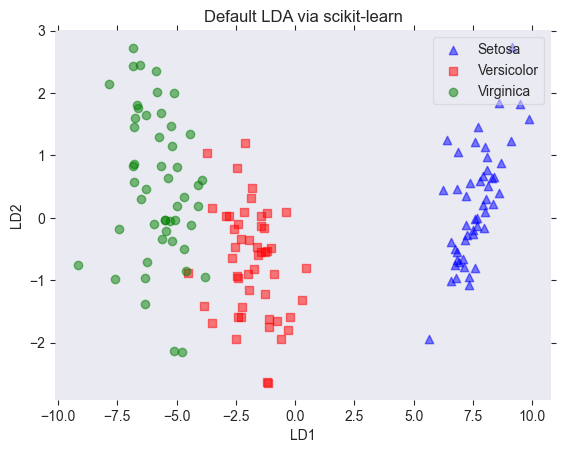

In [29]:
plot_step_lda()
plot_scikit_lda(X_lda_sklearn, title='Default LDA via scikit-learn')

# Übung

Welchen Effekt hat Standardisierung auf das Ergebnis der LDA? Probiere es aus und interpretiere das Ergebnis.

In [30]:
from sklearn.preprocessing import StandardScaler

ssc = StandardScaler()
ssc.fit(X_train)
X_train_z = ssc.transform(X_train)

sklearn_lda = LDA()
X_lda_sklearn2 = sklearn_lda.fit_transform(X_train_z, y_train)

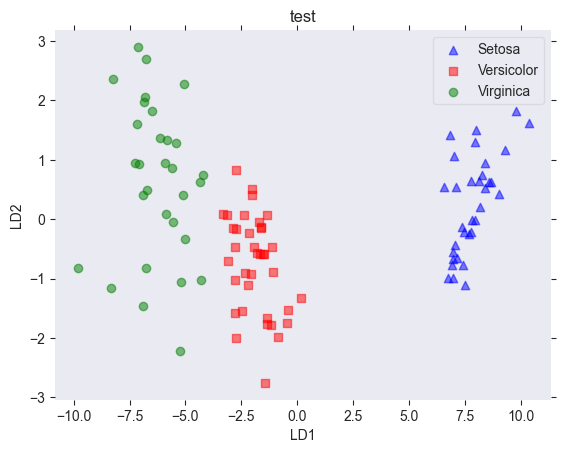

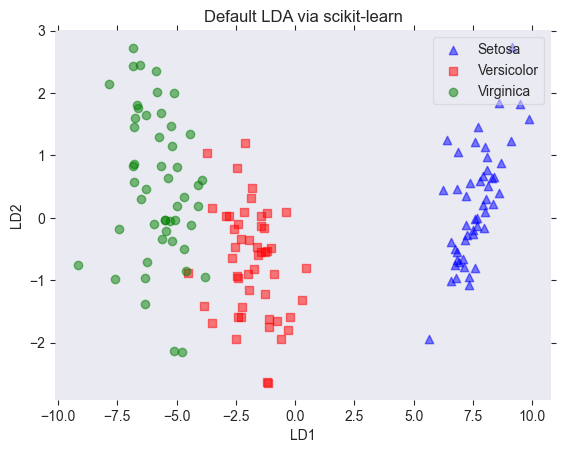

In [38]:
ax = plt.subplot(111)
for label, marker, color in zip(
        range(1, 4), ('^', 's', 'o'), ('blue', 'red', 'green')):
    plt.scatter(x=X_lda_sklearn2[:, 0][y_train == label],
                y=X_lda_sklearn2[:, 1][y_train == label] * -1,  # flip the figure
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label])

plt.xlabel('LD1')
plt.ylabel('LD2')

leg = plt.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.5)
plt.title("test")

# hide axis ticks
plt.tick_params(axis="both", which="both", bottom="off", top="off",
                labelbottom="on", left="off", right="off", labelleft="on")

# remove axis spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

plt.grid()
plt.tight_layout
plt.show()

plot_scikit_lda(X_lda_sklearn, title='Default LDA via scikit-learn')